# Filters
In this notebook, the following steps are accomplished:
1.  Raw streamflow data is pulled
2.  Holes in the data are filled using data from the previous year
3.  A variety of filtering techniques are applied to the data to reduce noise

## Notes
Questions:
* Train on all 3 rivers, or individual rivers? River transfer knowledge?
* Which giver better result for 5 day forcast: seq to seq or rolling predictions?

In [3]:
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import datetime
from dateutil.relativedelta import relativedelta
from pandas import DataFrame
#from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
rcParams['axes.titlesize'] = 'xx-large'
rcParams['axes.titleweight'] = 'bold'
rcParams["legend.loc"] = 'upper left'
look = 21
lead = 1 # 3, 5, 7, 10
plt.rcParams['figure.figsize'] = [20, 10]


## Raw Data
In this step, the raw data is pulled, and each river's flow becomes the column of the dataframe 'flows'
indexed temporally.

In [4]:
#1934-4-01  2018-07-09
df = pd.read_csv('../../data/streamflw_precipitation/Ganges.csv', usecols=[3,4], index_col=0,header=0,parse_dates=True) #Brahmaputra #Meghna
df1 = pd.read_csv('../../data/streamflw_precipitation/Brahmaputra.csv', usecols=[3,4], index_col=0,header=0,parse_dates=True) #Brahmaputra #Meghna
df2 = pd.read_csv('../../data/streamflw_precipitation/Meghna.csv', usecols=[3,4], index_col=0,header=0,parse_dates=True) #Brahmaputra #Meghna

Ganges      = df["Q (m3/s)"].loc['1980-01-01':]
Brahmaputra = df1["Q (m3/s)"].loc['1980-01-01':]
Meghna      = df2["Q (m3/s)"].loc['1980-01-01':]


flows = pd.concat([Ganges, Brahmaputra, Meghna], axis=1, sort=False)
flows.columns = ['Ganges', 'Brahmaputra', 'Meghna']


print(flows.head(3))
print(flows.tail(3))

            Ganges  Brahmaputra  Meghna
Date                                   
1980-01-01  1600.0       7500.0    92.3
1980-01-02  1620.0       7300.0    91.4
1980-01-03  1620.0       7100.0    90.6
            Ganges  Brahmaputra  Meghna
Date                                   
2018-07-07  5337.0      61665.0  2470.0
2018-07-08  6366.0      62437.0  2965.0
2018-07-09  7206.0      61921.0  2999.0


In [5]:
# Makes plots a reasonable size
plt.rcParams['figure.figsize'] = [20, 10]

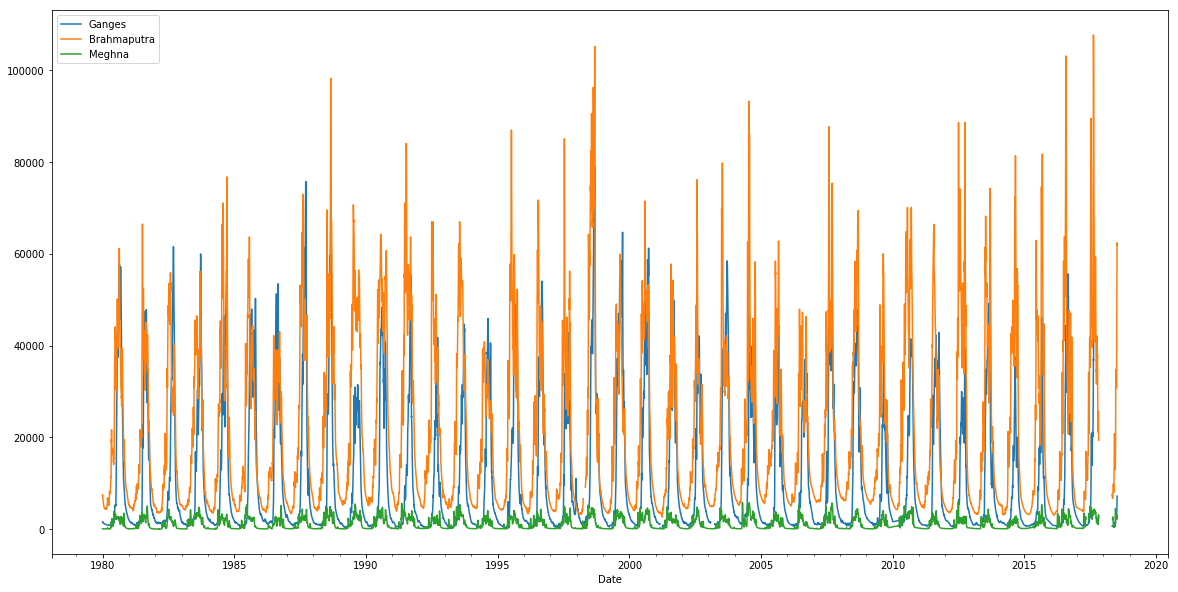

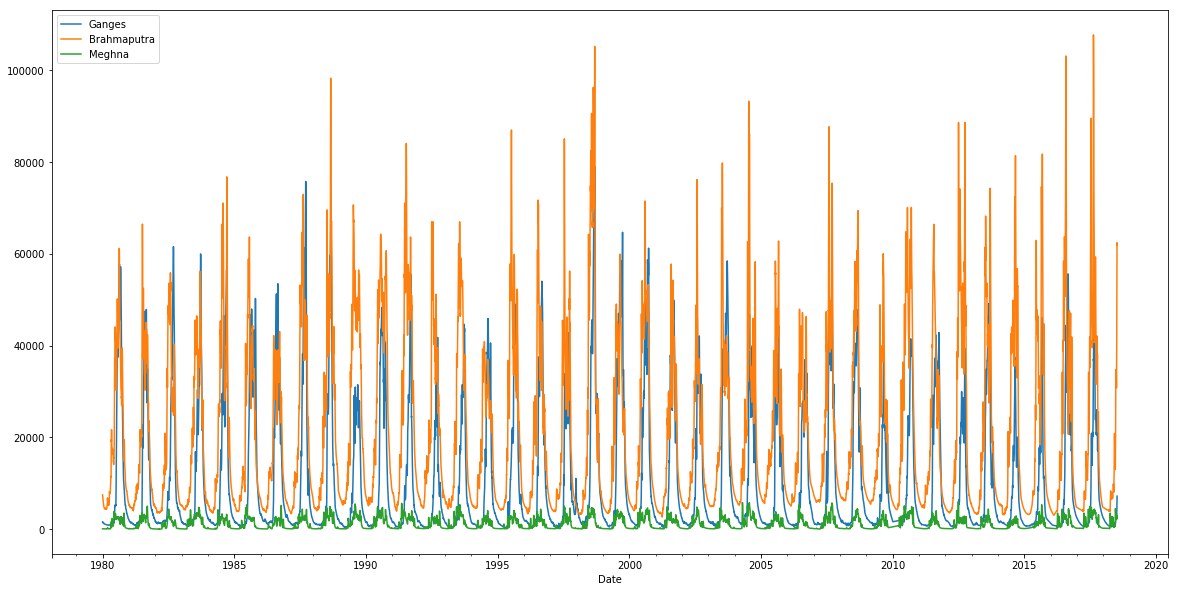

pandas.core.frame.DataFrame

In [6]:
'''
print(flows[flows.iloc[:,0].isnull()])
flows[flows.iloc[:,0].isnull()] = flows.iloc[:,0].groupby([df['Date'].dt.month,df['Date'].dt.day].shift())
print(flows[flows.iloc[:,0].isnull()])
'''

# fills NaNs with previous year
def replace_NaN(column):

    NaNs = column[column.isnull()]
    #NaNs_initial = NaNs = column[]
    for i in range (len(NaNs)):
        current = NaNs.index[i]
        prv = current - relativedelta(years=1) #,'''days = 1''')
        #add condition to see if there is a previous datapoint and if it's not null, else go into the future
        #a mask could work here to select all of the same month and year and find the closest value
        #then impliment alg bellow
        column[current] = column[prv]
        #column[current] = seasonality[current] #replacing with average value may be preferable
    return column

        
    
#df['Ganges'].groupby([flows.index.month,flows.index.day])
flows.plot()
plt.show()


flows[flows.columns] = flows[flows.columns].apply(replace_NaN)


flows.plot()
plt.show()
type(flows)

##  Mean Day%Year Flow
average_season() returns the mean flow for a given day of a given month over the course of a year
extract_avg_seasonality() returns an annual mean daily flow tiled to the length of the dataset
(see plots)

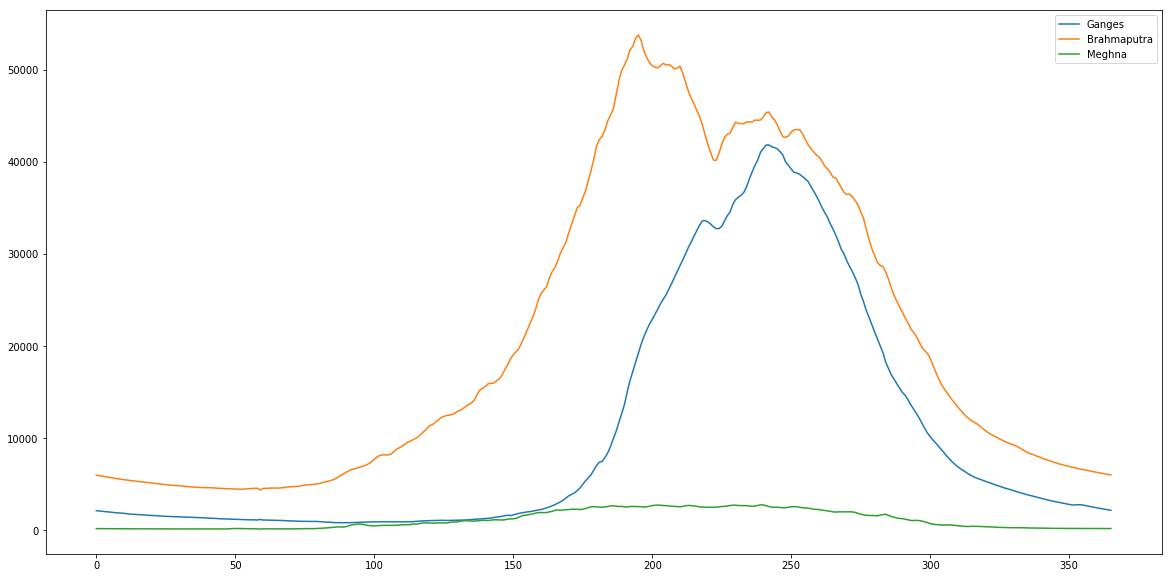

<Figure size 14400x1080 with 0 Axes>

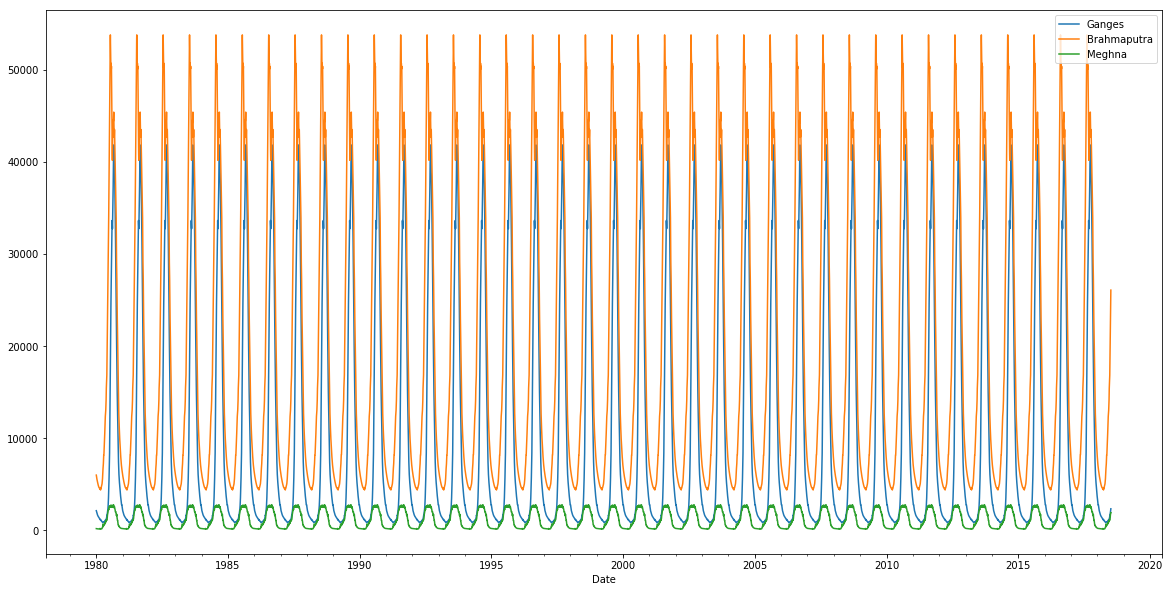

In [8]:
def extract_avg_seasonality(ts):
    avgSeason = average_season(ts)
    
    n = len(ts)/len(avgSeason) + 1
        
    avgSeasons = pd.concat([avgSeason] * n, ignore_index=True)
    
    avgSeasons = avgSeasons.iloc[:len(ts)]
    
    avgSeasons = avgSeasons.set_index(ts.index)
    
    avgSeasons.columns = ts.columns
    
    return avgSeasons

# Helper function that returns the average year flow
def average_season(ts):
    avg_season =  np.array(ts.groupby([ts.index.month,ts.index.day]).mean())
    avg_season = pd.DataFrame(avg_season)
    avg_season.columns = ts.columns
    return avg_season

# The average year visualized
average_season(flows).plot()
plt.show()

seasonality = extract_avg_seasonality(flows)
figure(figsize=(200,15))
seasonality.plot()
plt.show()


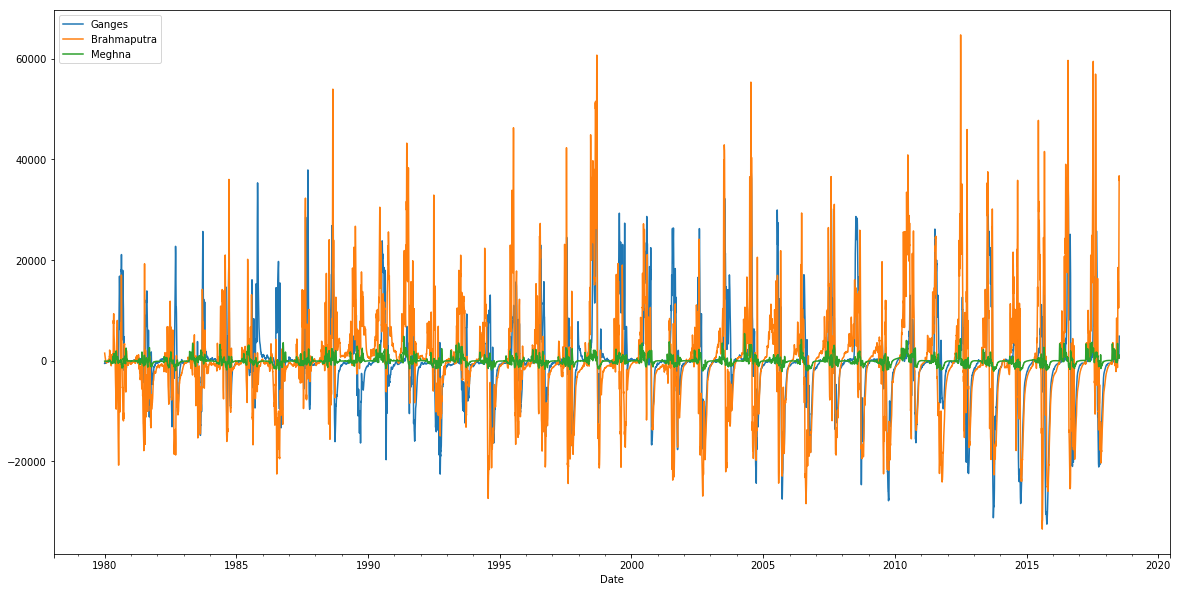

In [9]:
flows_unseasoned = flows - seasonality

# Data with average subtracted
flows_unseasoned.plot()
plt.show()

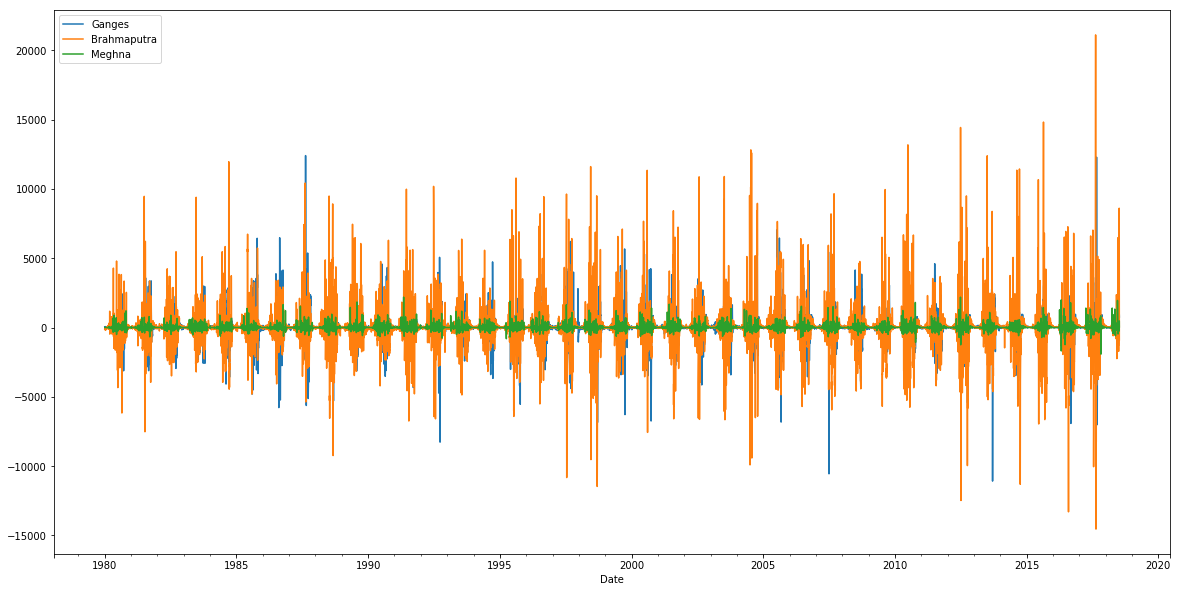

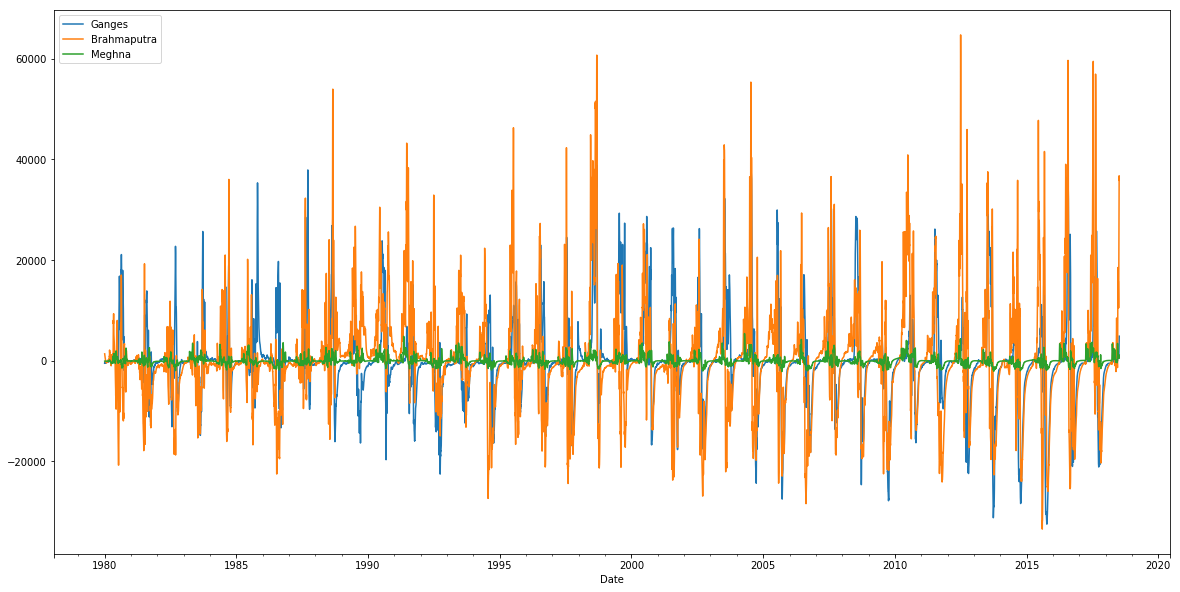

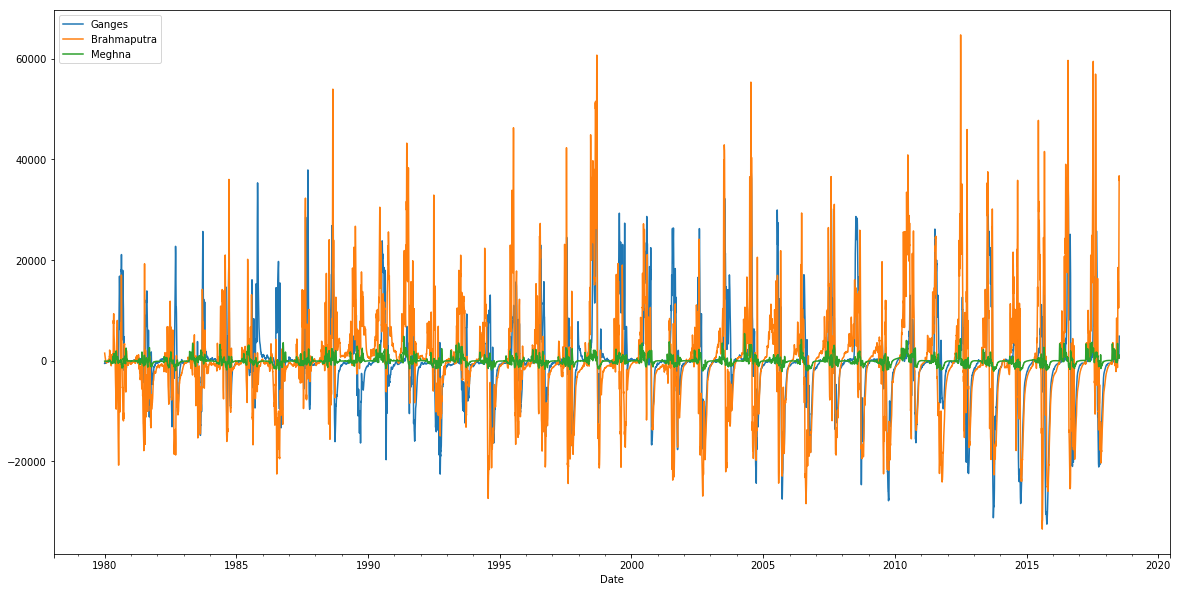

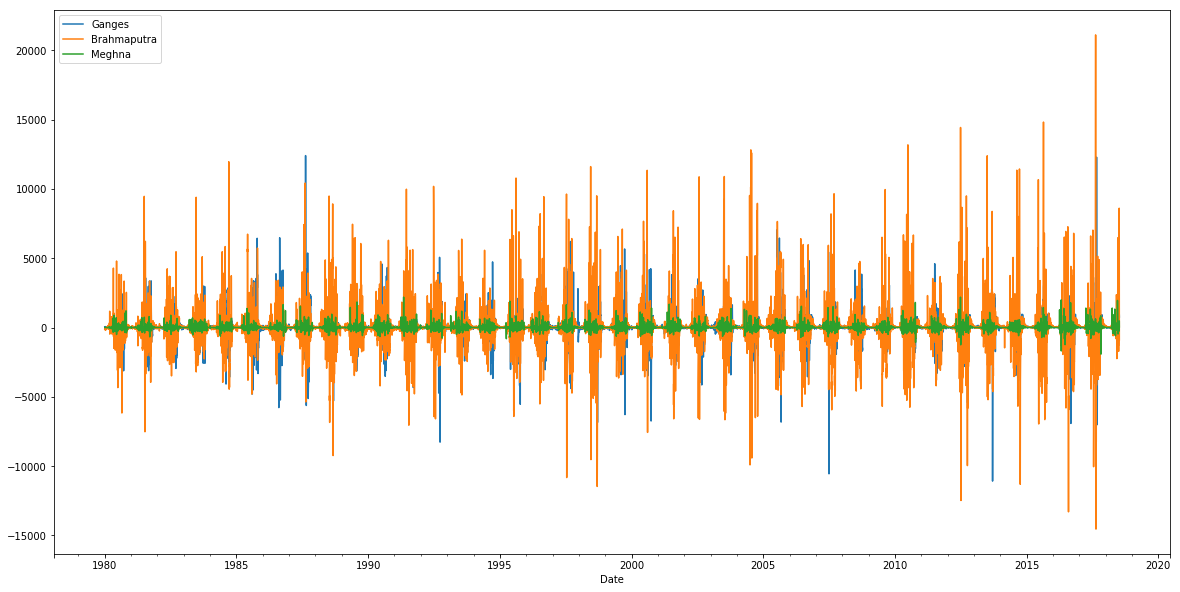

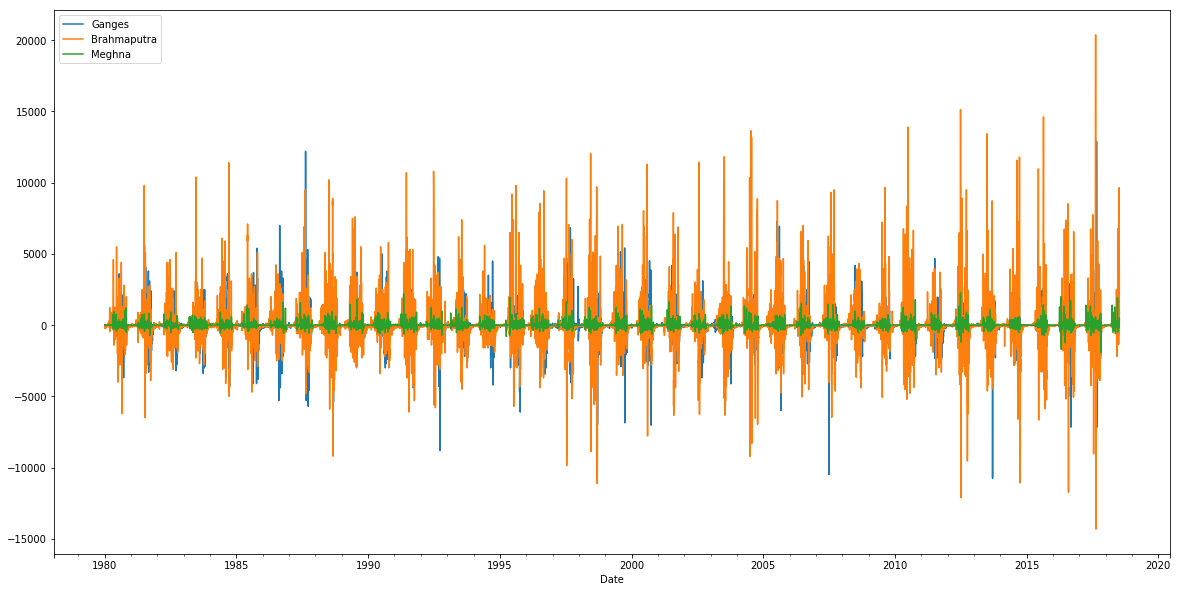

In [10]:
# returns the differenced dataframe
def diff(df):
    return df.diff()

#inverts differencing
def invert_diff(df, ic):
    return ic + df.cumsum()

diffed = diff(flows_unseasoned)
diffed.plot()
invert_diff(diff(flows_unseasoned), flows_unseasoned.iloc[0]).plot()
flows_unseasoned.plot()
(diff(flows) - extract_avg_seasonality(diff(flows))).plot()
diff(flows).plot()

plt.show()
    

<Figure size 14400x1080 with 0 Axes>

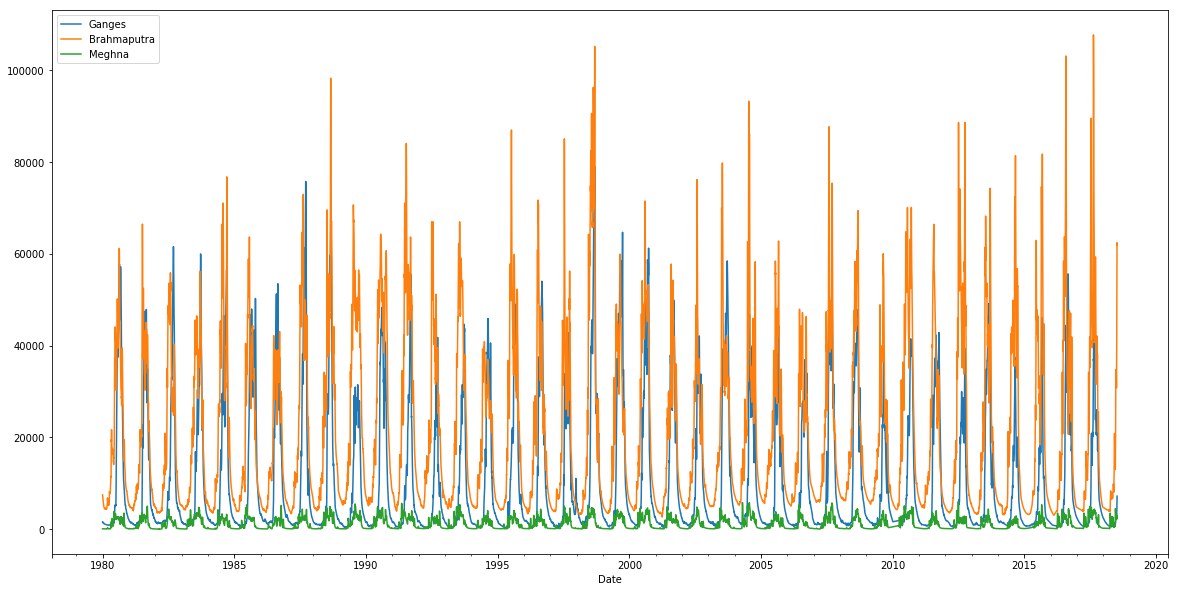

In [11]:
figure(figsize=(200,15))
flows.plot()
plt.show()

# Filters

Data

Rolling Mean Filter

In [12]:
flows_RM = flows.rolling(window=7).mean()


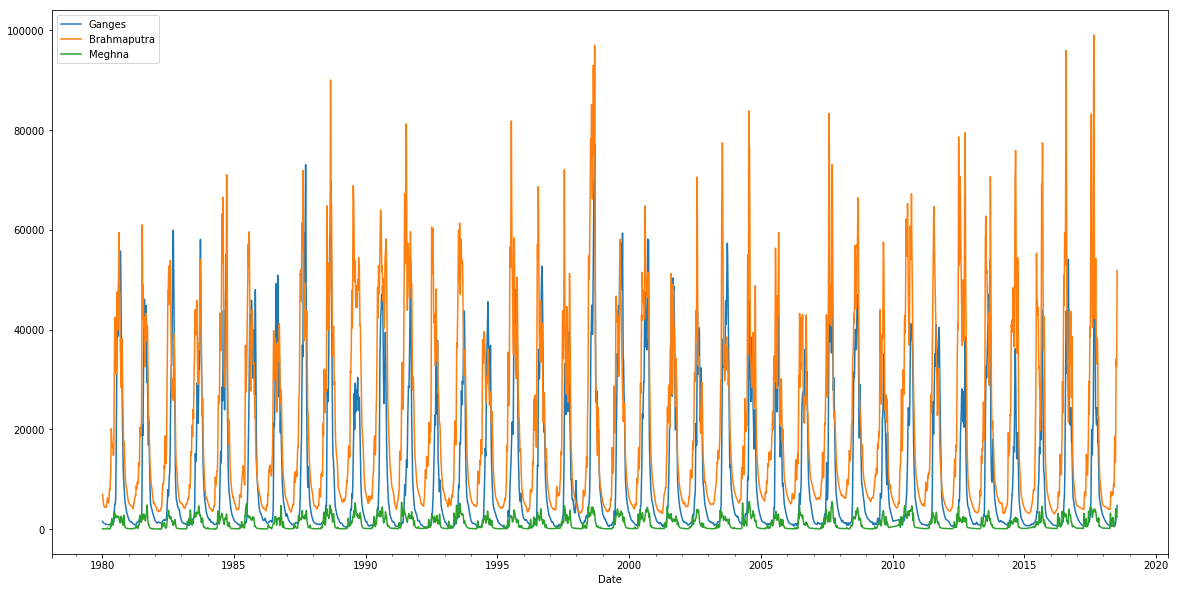

In [13]:
#print(flows_RM)
#print(len(flows_RM))
flows_RM.plot()
plt.show()

In [14]:
"""
lowess: Locally linear regression  
==================================
Implementation of the LOWESS algorithm in n dimensions.
References
=========
[HTF] Hastie, Tibshirani and Friedman (2008). The Elements of Statistical
Learning; Chapter 6 
[Cleveland79] Cleveland (1979). Robust Locally Weighted Regression and Smoothing
Scatterplots. J American Statistical Association, 74: 829-836.
"""

import numpy.linalg as la


# Kernel functions:
def epanechnikov(xx, **kwargs):
    """
    The Epanechnikov kernel estimated for xx values at indices idx (zero
    elsewhere) 
    Parameters
    ----------
    xx: float array
        Values of the function on which the kernel is computed. Typically,
        these are Euclidean distances from some point x0 (see do_kernel)
    Notes
    -----
    This is equation 6.4 in HTF chapter 6        
    
    """
    l = kwargs.get('l', 1.0)
    ans = np.zeros(xx.shape)
    xx_norm = xx / l
    idx = np.where(xx_norm <= 1)
    ans[idx] = 0.75 * (1 - xx_norm[idx]  ** 2)
    return ans


def tri_cube(xx, **kwargs):
    """ 
    The tri-cube kernel estimated for xx values at indices idx (zero
    elsewhere) 
    Parameters
    ----------
    xx: float array
        Values of the function on which the kernel is computed. Typically,
        these are Euclidean distances from some point x0 (see do_kernel)
    idx: tuple
        An indexing tuple pointing to the coordinates in xx for which the
        kernel value is estimated. Default: None (all points are used!)  
    Notes
    -----
    This is equation 6.6 in HTF chapter 6        
    """        
    ans = np.zeros(xx.shape)
    idx = np.where(xx <= 1)
    ans[idx] = (1 - np.abs(xx[idx]) ** 3) ** 3
    return ans


def bi_square(xx, **kwargs):
    """
    The bi-square weight function calculated over values of xx
    Parameters
    ----------
    xx: float array
    Notes
    -----
    This is the first equation on page 831 of [Cleveland79].
    """
    ans = np.zeros(xx.shape)
    idx = np.where(xx < 1)
    ans[idx] = (1 - xx[idx] ** 2) ** 2
    return ans


def do_kernel(x0, x, l=1.0, kernel=epanechnikov):
    """
    Calculate a kernel function on x in the neighborhood of x0
    Parameters
    ----------
    x: float array
       All values of x
    x0: float
       The value of x around which we evaluate the kernel
    l: float or float array (with shape = x.shape)
       Width parameter (metric window size)
    kernel: callable
        A kernel function. Any function with signature: `func(xx)`    
    """
    # xx is the norm of x-x0. Note that we broadcast on the second axis for the
    # nd case and then sum on the first to get the norm in each value of x:
    xx = np.sum(np.sqrt(np.power(x - x0[:, np.newaxis], 2)), 0)
    return kernel(xx, l=l)


def lowess(x, y, x0, deg=1, kernel=epanechnikov, l=1, robust=False,):
    """
    Locally smoothed regression with the LOWESS algorithm.
    Parameters
    ----------
    x: float n-d array  
       Values of x for which f(x) is known (e.g. measured). The shape of this
       is (n, j), where n is the number the dimensions and j is the
       number of distinct coordinates sampled.
    
    y: float array
       The known values of f(x) at these points. This has shape (j,) 
    x0: float or float array.
        Values of x for which we estimate the value of f(x). This is either a
        single scalar value (only possible for the 1d case, in which case f(x0)
        is estimated for just that one value of x), or an array of shape (n, k).
    deg: int
        The degree of smoothing functions. 0 is locally constant, 1 is locally
        linear, etc. Default: 1.
        
    kernel: callable
        A kernel function. {'epanechnikov', 'tri_cube', 'bi_square'}
    l: float or float array with shape = x.shape
       The metric window size for the kernel
    robust: bool
        Whether to apply the robustification procedure from [Cleveland79], page
        831
    
        
    Returns
    -------
    The function estimated at x0. 
    Notes
    -----
    The solution to this problem is given by equation 6.8 in Hastie
    Tibshirani and Friedman (2008). The Elements of Statistical Learning
    (Chapter 6). 
    Example
    -------
    >>> import lowess as lo
    >>> import numpy as np
    # For the 1D case:
    >>> x = np.random.randn(100)
    >>> f = np.cos(x) + 0.2 * np.random.randn(100)
    >>> x0 = np.linspace(-1, 1, 10)
    >>> f_hat = lo.lowess(x, f, x0)
    >>> import matplotlib.pyplot as plt
    >>> fig, ax = plt.subplots(1)
    >>> ax.scatter(x, f)
    >>> ax.plot(x0, f_hat, 'ro')
    >>> plt.show()
    # 2D case (and more...)
    >>> x = np.random.randn(2, 100)
    >>> f = -1 * np.sin(x[0]) + 0.5 * np.cos(x[1]) + 0.2*np.random.randn(100)
    >>> x0 = np.mgrid[-1:1:.1, -1:1:.1]
    >>> x0 = np.vstack([x0[0].ravel(), x0[1].ravel()])
    >>> f_hat = lo.lowess(x, f, x0, kernel=lo.tri_cube)
    >>> from mpl_toolkits.mplot3d import Axes3D
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111, projection='3d')
    >>> ax.scatter(x[0], x[1], f)
    >>> ax.scatter(x0[0], x0[1], f_hat, color='r')
    >>> plt.show()
    """
    if robust:
        # We use the procedure described in Cleveland1979
        # Start by calling this function with robust set to false and the x0
        # input being equal to the x input:
        y_est = lowess(x, y, x, kernel=epanechnikov, l=l, robust=False)
        resid = y_est - y
        median_resid = np.nanmedian(np.abs(resid))
        # Calculate the bi-cube function on the residuals for robustness
        # weights: 
        robustness_weights = bi_square(resid / (6 * median_resid))
        
    # For the case where x0 is provided as a scalar: 
    if not np.iterable(x0):
       x0 = np.asarray([x0])
    ans = np.zeros(x0.shape[-1]) 
    # We only need one design matrix for fitting:
    B = [np.ones(x.shape[-1])]
    for d in range(1, deg+1):
        B.append(x ** deg)

    B = np.vstack(B).T
    for idx, this_x0 in enumerate(x0.T):
        # This is necessary in the 1d case (?):
        if not np.iterable(this_x0):
            this_x0 = np.asarray([this_x0])
        # Different weighting kernel for each x0:
        W = np.diag(do_kernel(this_x0, x, l=l, kernel=kernel))
        # XXX It should be possible to calculate W outside the loop, if x0 and
        # x are both sampled in some regular fashion (that is, if W is the same
        # matrix in each iteration). That should save time.

        if robust:
            # We apply the robustness weights to the weighted least-squares
            # procedure:
            robustness_weights[np.isnan(robustness_weights)] = 0
            W = np.dot(W, np.diag(robustness_weights))
        #try: 
        # Equation 6.8 in HTF:
        BtWB = np.dot(np.dot(B.T, W), B)
        BtW = np.dot(B.T, W)
        # Get the params:
        beta = np.dot(np.dot(la.pinv(BtWB), BtW), y.T)
        # We create a design matrix for this coordinat for back-predicting:
        B0 = [1]
        for d in range(1, deg+1):
            B0 = np.hstack([B0, this_x0 ** deg])
        B0 = np.vstack(B0).T
        # Estimate the answer based on the parameters:
        ans[idx] += np.dot(B0, beta)
    # If we are trying to sample far away from where the function is
    # defined, we will be trying to invert a singular matrix. In that case,
    # the regression should not work for you and you should get a nan:
        #except la.LinAlgError :
        #    ans[idx] += np.nan
    return ans.T

halts

In [12]:
#too slow, commented out for now
'''
def df_lowess(df):
    endog = np.arange(len(df.index))
    exog = df.values
    x0 = np.linspace(0, len(df.index),  len(df.index))
    return lowess(endog, exog, x0, l = 7)



print(type(flows))
low = df_lowess(flows['Meghna'])
'''

"\ndef df_lowess(df):\n    endog = np.arange(len(df.index))\n    exog = df.values\n    x0 = np.linspace(0, len(df.index),  len(df.index))\n    return lowess(endog, exog, x0, l = 7)\n\n\n\nprint(type(flows))\nlow = df_lowess(flows['Meghna'])\n"

In [15]:
# Local Regression
from statsmodels.nonparametric import smoothers_lowess

[  92.3   91.4   90.6 ... 2470.  2965.  2999. ]
..................
..................
[7113.79483847 7113.88014683 7113.95597648 ... 6900.88650368 6846.20105283
 6848.94965283]
[  92.3   91.4   90.6 ... 2470.  2965.  2999. ]


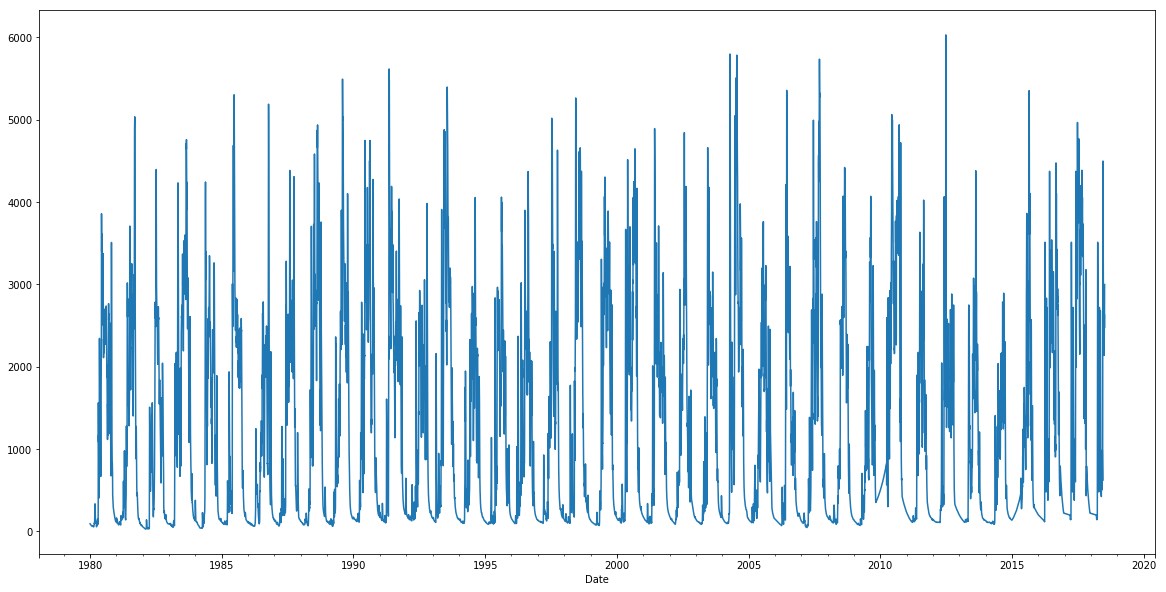

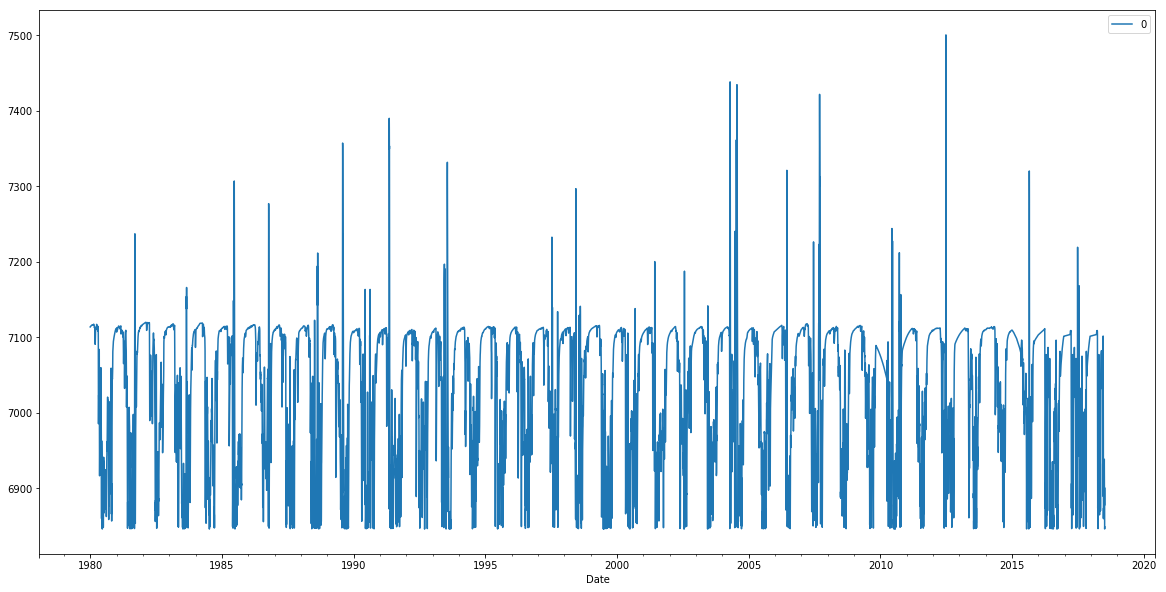

In [16]:


print(flows['Meghna'].values)
print('..................')
print('..................')
#print(range(len(flows.index)))

endog = range(len(flows.index))
exog = flows['Meghna'].values

flows_SL = smoothers_lowess.lowess(endog,
                        exog,
                        frac=1,
                        it=3, 
                        delta=0.01 * len(exog),
                        is_sorted=False,
                        missing='drop',
                        return_sorted=False)

flows_SL = pd.DataFrame(flows_SL, index = flows.index)

print(flows_SL.iloc[:,0].values)

print(flows['Meghna'].values)
                        
flows['Meghna'].plot()
flows_SL.plot()

http://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html

In [17]:
# Savitzky-Golay and hamming
from scipy.signal import savgol_filter, hamming

https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html

In [18]:
def savgol(df):
    df = df
    filtered = savgol_filter(df.values, window_length = 101,
                             polyorder = 3)
    
    return filtered

In [19]:
savgol(flows['Meghna'] - flows['Meghna'].values)

/usr/local/lib/python2.7/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


array([0., 0., 0., ..., 0., 0., 0.])

flat:
hanning:
hamming:
bartlett:
blackman:


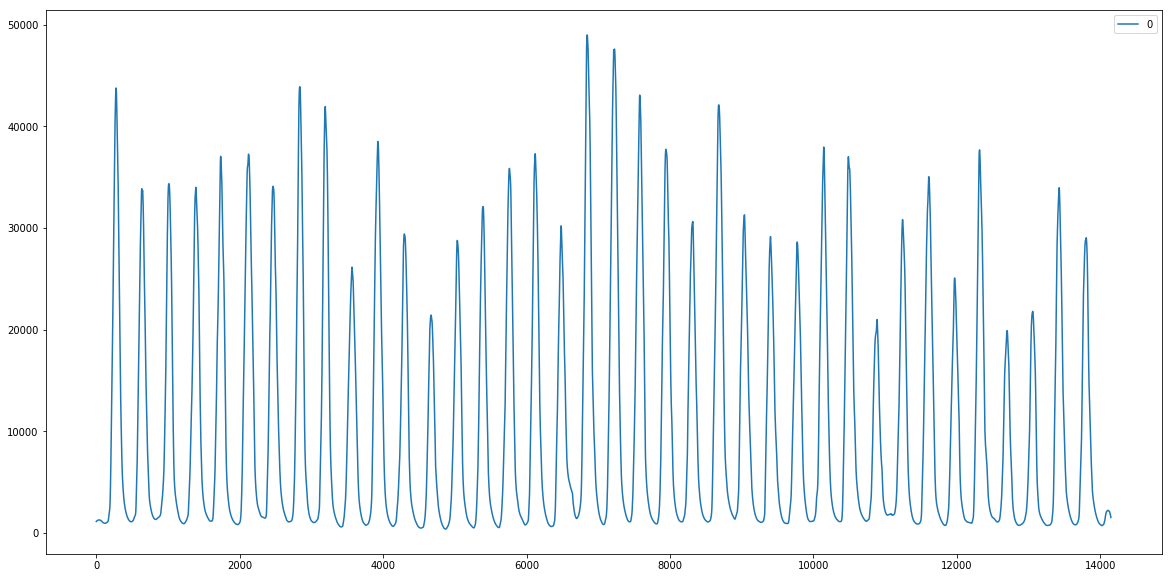

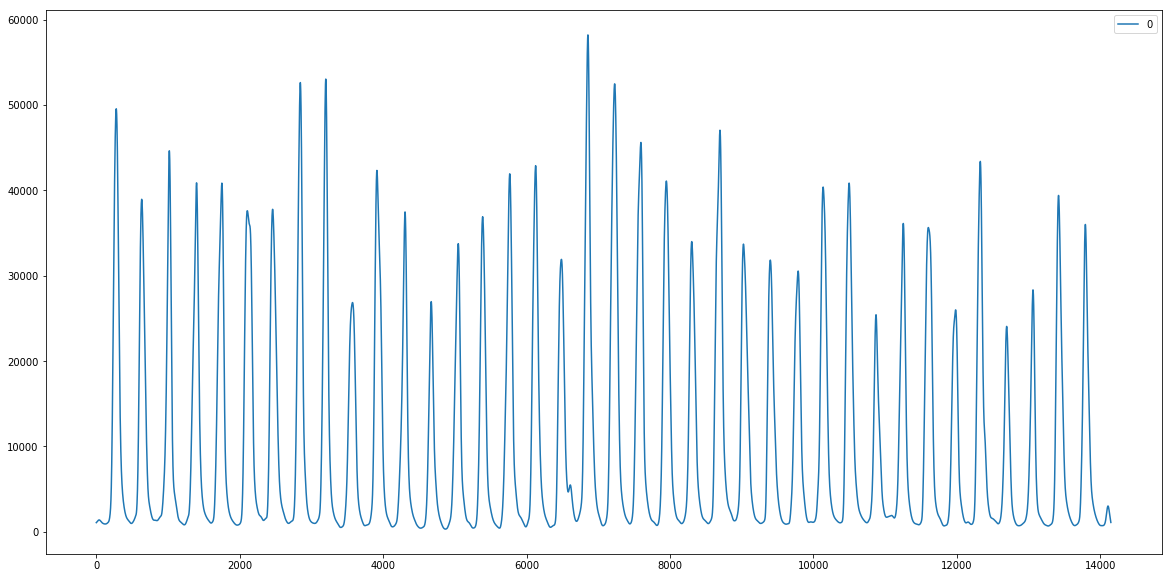

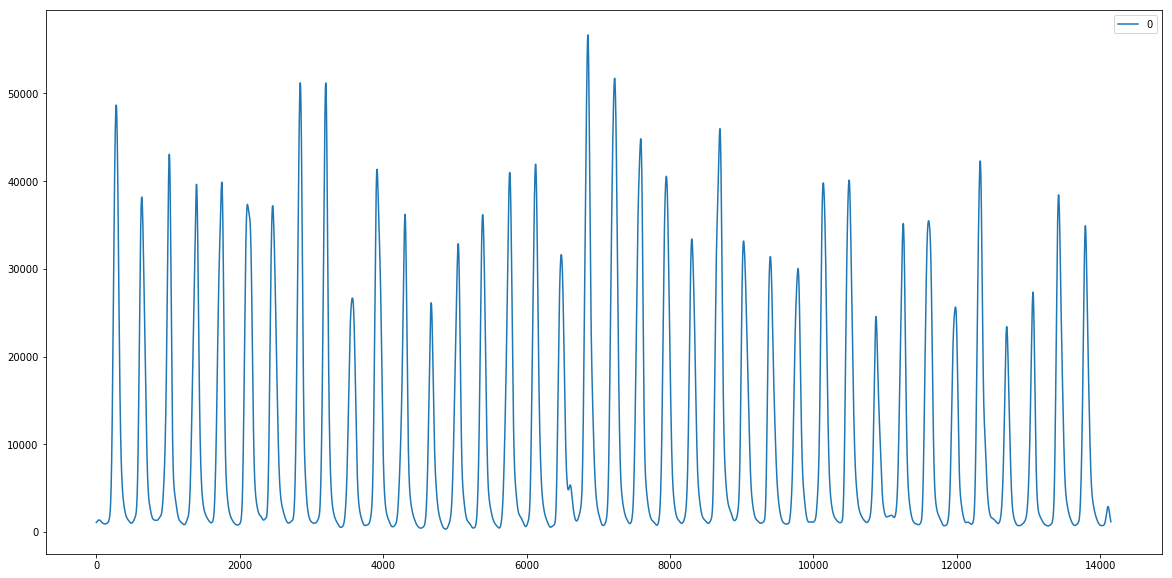

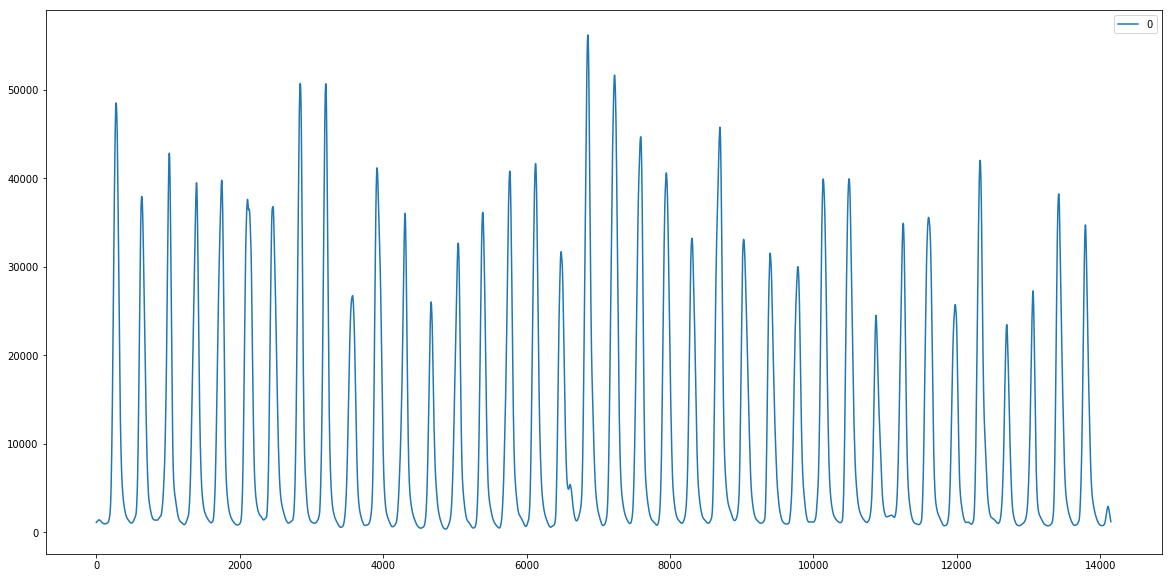

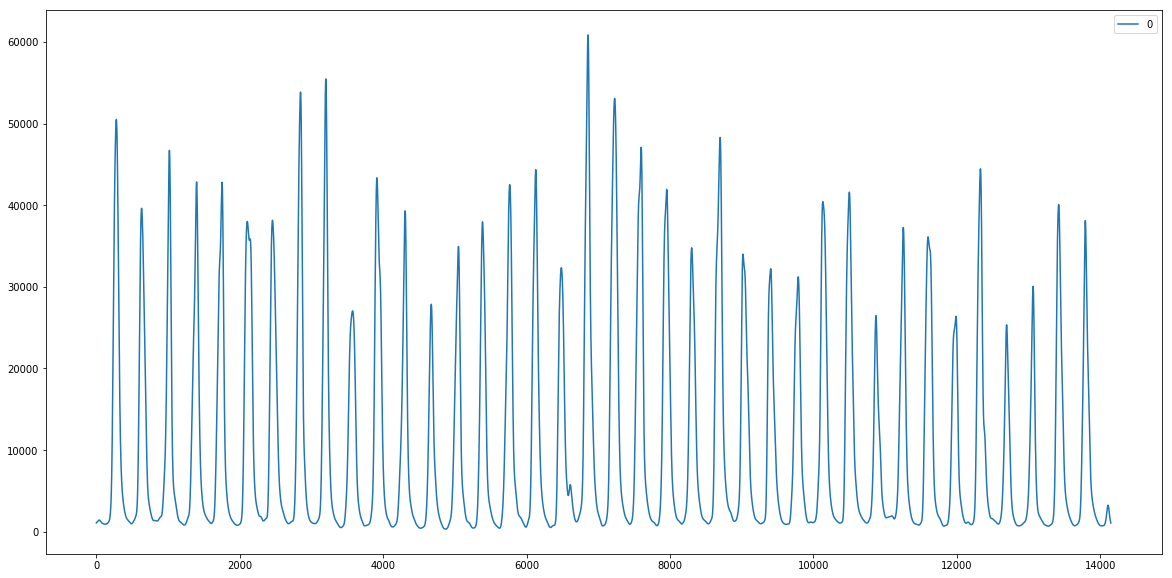

In [20]:
def smooth(x, window_len = 3, window='hanning'):
    if x.ndim !=1:
        raise ValueError, "smooth only accepts 1d arrays."
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
    
    if window_len<3:
        raise ValueError, "Window length should be bigger than 3 for filtering"
        
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    
    if window =='flat':
        w = np.ones(window_len, 'd')
    
    else:
        w = eval('np.'+window+'(window_len)')
        
    y = np.convolve(w/w.sum(),s,mode='valid')
    
    y = pd.DataFrame(y)
    return y


print('flat:')
smooth(flows['Ganges'], window_len = 80, window = 'flat').plot()
print('hanning:')
smooth(flows['Ganges'], window_len = 80, window = 'hanning').plot()
print('hamming:')
smooth(flows['Ganges'], window_len = 80, window = 'hamming').plot()
print('bartlett:')
smooth(flows['Ganges'], window_len = 80, window = 'bartlett').plot()
print('blackman:')
smooth(flows['Ganges'], window_len = 80, window = 'blackman').plot()


plt.show()

In [21]:

'''
print(df_SG)
print(len(df_SG))
flows_SG.plot()
plt.show()
'''

'\nprint(df_SG)\nprint(len(df_SG))\nflows_SG.plot()\nplt.show()\n'

In [36]:

print(len(flows.loc['1986-04-01':'1986-09-30'].index))


183


In [ ]:
def lenCheck(df):
    df = df[(pd.DatetimeIndex(df['Date']).year = 1984)]
    df = df[(pd.DatetimeIndex(df['Date']).month > 4)   &  (pd.DatetimeIndex(df['Date']).month <10)]
    return len(df.index)

lenCheck(flows)

https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.hamming.html#scipy.signal.hamming

In [30]:
def rolling_windowXY(df):
    df = df.reset_index()
    
    for lag in np.arange(-20,16):
        
        new_index = df.index + lag
        x = df.loc[new_index, df.columns[0]]
        x = pd.DataFrame(x)
        x.columns = [''.join(['Q_',str(lag)])]   
        x.index = df.index
        df = pd.concat([df,x],axis=1)
    '''   
    print('DF: ')
    print(df)
    '''  
    
    #filter dates
    df = df[(pd.DatetimeIndex(df['Date']).year > 1984) & (pd.DatetimeIndex(df['Date']).year <2017)]
    df = df[(pd.DatetimeIndex(df['Date']).month > 4)   &  (pd.DatetimeIndex(df['Date']).month <10)]

    columns = df.columns.values.tolist()
    for lag in np.arange(1,16):
        columns.append(''.join(['Q_',str(lag)]))
    
    Y_df = df[columns]

    columns = df.columns.values.tolist()
    
    for lag in np.arange(-20,1):
        columns.append(''.join(['Q_',str(lag)]))    
        
    X_df = df[columns]
    
    return X_df , Y_df
    
Qx, Qy = rolling_windowXY(flows)
'''
print('Qx:')
print(Qx)
print('Qy:')
print(Qy)
'''


SyntaxError: invalid syntax (<ipython-input-30-9a02f70f97af>, line 44)

1st create samples, build models, train models, evaluate on test set

loop through different filters and different rivers

3 rivers 5 filters 6 models
subplots 5 row 6 columns each figure has all 3 rivers

finish filters!

compare baseline with residual

In [ ]:
X = np.swapaxes(Qx.values[np.newaxis], 0, 1)
y = np.swapaxes(Qy.values[np.newaxis], 0, 1)

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
print(len(Qx.columns))

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Conv1D,Flatten

from tensorflow.keras import initializers, regularizers

from keras_pandas.Automater import Automater

## Params
Default params for networks

In [ ]:
# Rolling window of X
rolling_window = len(Qx.columns)

# of epochs
numEpoch = 5

# Which day are we predicting?
y = Qy['Q_1']
y.head().squeeze()

In [ ]:
l2 = regularizers.l2
bias = initializers.glorot_uniform(seed = 0)
#kernal = 

## Dense

In [ ]:
def initDense():
    # Initialize network as sequential
    model = Sequential()
    
    # Add reccurant layer
    model.add(Dense(10,
                        input_shape = (1, rolling_window),))
    
    # Add dense layer
    model.add(Dense(1,))
    
    #return model
    return model
    
initDense().summary()

## RNN

In [ ]:
def initRNN():
    # Initialize network as sequential
    model = Sequential()
        
    # Add reccurant layer
    model.add(SimpleRNN(10,
                        input_shape = (1, rolling_window),))
    
    # Syncronize with input shape    
    #model.add(Flatten())

    
    # Add dense layer
    model.add(Dense(1))
    
    #return model
    return model
    
initRNN().summary()

## LSTM

In [ ]:
def initLSTM():
    # Initialize network as sequential
    model = Sequential()
    
    # Add reccurant LSTM layer
    model.add(LSTM(10,
                        input_shape = (1, rolling_window),))
    
    # Add dense layer
    model.add(Dense(1,))
    
    #return model
    return model
    
initLSTM().summary() 

# CNN
Issues:
Input shape dimensionality

In [ ]:
def initCNN():
    # Initialize network as sequential
    model = Sequential()
    
    # Add reccurant LSTM layer
    model.add(Conv1D(filters = 10, kernel_size = 2, input_shape = (1, rolling_window),))
    model.add(Flatten())
    # Add dense layer
    model.add(Dense(1,))
    
    #return model
    return model
    
initConv1D().summary() 

## Arima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
QxV = Qx.values
print(QxV)
print(QxV.shape)
print(Qx)
print(Qx.shape)

# TODO:
MAKE EACH YEAR A BATCH!!!

In [ ]:
RNN = initRNN()
RNN.compile(loss='mean_squared_error', optimizer = 'adam')
print(RNN.input_shape)
RNN.fit(X, y, epochs = numEpoch,  batch_size=1, 
         verbose=2, validation_split = .1)

In [ ]:
LSTM = initLSTM()
LSTM.compile(loss='mean_squared_error', optimizer = 'adam')
print(LSTM.input_shape)
LSTM.fit(X, y, epochs = numEpoch,  batch_size=1, 
         verbose=2, validation_split = .1)

In [ ]:
# Need to reshape dimensions for dense, see colab notebook

Dense = initDense()
Dense.compile(loss='mean_squared_error', optimizer = 'adam')
print(Dense.input_shape)
Dense.fit(X, y, epochs = numEpoch,  batch_size=1, 
         verbose=2, validation_split = .1)